# Libraries

In [32]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from image_load_preprocess import *
from CNN_builder import *

# Load and preprocess images

In [33]:
# Global variables
n_classes = 43 # Number of traffic road sign classes
img_height = 40 # Images height (photos to be transformed to this)
img_width = 40 # Images width (photos to be transformed to this)

In [34]:
# Load and preprocess training data
train_images, train_labels = load_preprocess_images("GTSRB data\Train", n_classes, img_height, img_width, 'train')

# Load and preprocess validation data
validation_images = load_preprocess_images("GTSRB data\Validation", n_classes, img_height, img_width, 'validation')
validation_labels = pd.read_csv("GTSRB data\Validation.csv")['ClassId']

# Optimising Convolutiona neural network structure

The training data only was used for the steps below

## Optimising convolution and pooling layers

### Model performance dataframe
A dataframe for recording the obtained accuracy for the different models structures investigated

In [5]:
column_names = ["conv_pool_pairs", "conv_kernel", "pool_kernel", "conv_filters", "conv_filters_rate",
                "hidden_dropout_pairs", "hidden_layer_size", "hidden_layer_rate", "dropout_rate", "training_accuracy", "testing_accuracy"]
model_perfromance_cp = pd.DataFrame(index=range(351),columns=column_names)

### Model training

In [21]:
# Global model training variables
epochs= 5
test_size = 0.25 # Fraction of images held-back for testing
repeats = 3 # Number of models trained for eachset of model building variables

In [22]:
# Fixed model building variables
hidden_dropout_pairs = 1 # Number of hidden and dropout layer pairs
hidden_layer_size = 128 # Number of neurons in hidden layer
hidden_layer_rate = 1 # Factor for increase of number of neurons in each subsequent hidden layer
dropout_rate = 0 # Dropout rate

In [7]:
# Model building variables to iterate over
conv_pool_pairs_list = [1,2,3] # Number of convolutional and pooling layer pairs
conv_kernel_list = [2,3,4] # Size of convolutional kernel (px)
pool_kernel_list = [2,3,4] # Size of pooling kernel (px) 
conv_filters_list = [16,32,64] # Number of filters in first convolution layer
conv_filters_rate_list = [1,2] # Factor for increase of number of filters in each subsequent convolutional layer

In [10]:
model_structure_number = 1 # Initiate

for i in conv_pool_pairs_list:

    # No need to vary over different convolutiona filter rates if only one convolutiona layer
    if i == 1:
        conv_filters_rate_list = [1] 
    else:
        conv_filters_rate_list = [1,2]
        
    # Pool kernel of 4 x 4 px reduces dimensions to negative if applied 3 times on 40 x 40 px images
    if i == 3:
        pool_kernel_list = [2,3]
    else:
        pool_kernel_list = [2,3,4]

    for j in conv_kernel_list:
        for k in pool_kernel_list:
            for l in conv_filters_list:
                for m in conv_filters_rate_list:
                    for n in range((repeats*model_structure_number-repeats), (repeats*(model_structure_number))):

                        # Record model structure used in model_perfromance dataframe
                        model_performance_cp['conv_pool_pairs'][n] = i
                        model_performance_cp['conv_kernel'][n] = j
                        model_performance_cp['pool_kernel'][n] = k
                        model_performance_cp['conv_filters'][n] = l
                        model_performance_cp['conv_filters_rate'][n] = m
                        model_performance_cp['hidden_dropout_pairs'][n] = hidden_dropout_pairs
                        model_performance_cp['hidden_layer_size'][n] = hidden_layer_size
                        model_performance_cp['hidden_layer_rate'][n] = hidden_layer_rate
                        model_performance_cp['dropout_rate'][n] = dropout_rate

                        # Build and compile CNN model 
                        model = build_model(img_height, img_width, n_classes, i, j, k, l, m,
                                            hidden_dropout_pairs, hidden_layer_size, hidden_layer_rate, dropout_rate, 'False')

                        # Train CNN model
                        tt_performance = train_model(train_images, train_labels, test_size, model, epochs)

                        # Record model performance on the training and testing data
                        model_performance_cp['training_accuracy'][n] = tt_performance.history['accuracy'][epochs-1]
                        model_performance_cp['testing_accuracy'][n] = tt_performance.history['val_accuracy'][epochs-1]

                    # Record in model structure number variable
                    model_structure_number += 1
                    
# Save results as CSV
model_performance_cp.to_csv("Model performance CP.csv", index = False)

### Comparisson of results

In [88]:
# Melt data
mp_cp_melt = pd.melt(model_performance_cp[["conv_pool_pairs", "conv_kernel", "pool_kernel", "conv_filters", "conv_filters_rate", "training_accuracy", "testing_accuracy"]], 
    id_vars =["conv_pool_pairs", "conv_kernel", "pool_kernel", "conv_filters", "conv_filters_rate"], 
    value_vars =["training_accuracy", "testing_accuracy"])


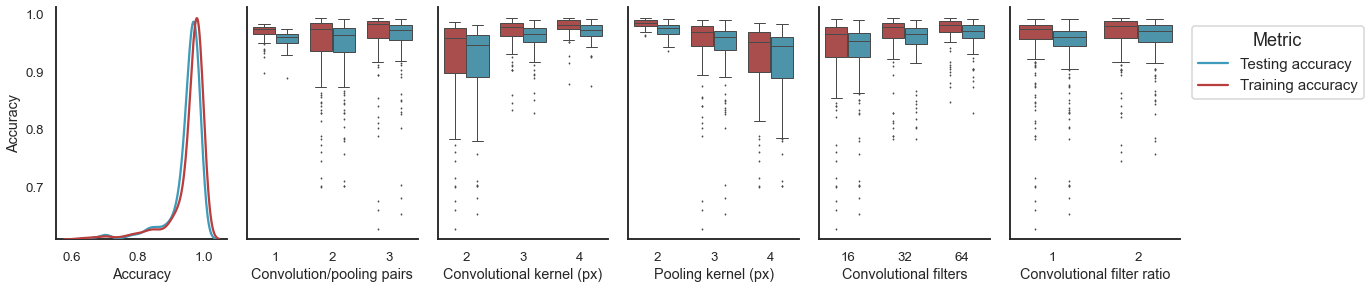

In [27]:
# Plot layout
sns.set_style("white")
sns.set_context("talk", font_scale = 0.8)

# Plot
plot = sns.PairGrid(data=mp_cp_melt, 
                    x_vars = ["value","conv_pool_pairs", "conv_kernel", "pool_kernel", "conv_filters", "conv_filters_rate"],
                    y_vars = ["value"],
                    hue="variable",
                    palette = ["#b93e3e", "#3e9bb9"],
                    height = 4,
                    aspect = 0.7,
                    layout_pad = 0.1)

plot.map_offdiag(sns.boxplot, linewidth = 1, fliersize = 1)
plot.map_diag(sns.kdeplot)

#Legend
legend = plt.legend(title = "Metric", 
                    labels=["testing_accuracy", "training_accuracy"], 
                    bbox_to_anchor=(7.7,0.95), 
                    title_fontsize = 18,
                    fontsize = 15, 
                    markerscale = 1.2)
legend.get_texts()[0].set_text('Testing accuracy')
legend.get_texts()[1].set_text('Training accuracy')

# Axes titles
axes_names = {'value':'Accuracy', 
              'conv_pool_pairs':'Convolution/pooling pairs',
              'conv_kernel':'Convolutional kernel (px)', 
              'pool_kernel':'Pooling kernel (px)',
              'conv_filters':'Convolutional filters',
              'conv_filters_rate':'Convolutional filter ratio'}
for i in range(6):
    if plot.axes[0][i].get_xlabel() in axes_names.keys():
        plot.axes[0][i].set_xlabel(axes_names[plot.axes[0][i].get_xlabel()])
    if plot.axes[0][i].get_ylabel() in axes_names.keys():
        plot.axes[0][i].set_ylabel(axes_names[plot.axes[0][i].get_ylabel()])

# PNG export
plt.savefig("Convolutional and pooling layers optimisation.png")

### Optimum convolutional and pooling layers parameters

In [134]:
# Weighted average accuracy
model_performance_cp['average_accuracy'] = (model_performance_cp["training_accuracy"]*3 + model_performance_cp["testing_accuracy"])/4

# Best model structure for predictions on both training and testing data over triplicate model training and evaluation
max_accuracy = 0 
for i in range(0,len(model_performance_cp),3):
    accuracy = model_performance_cp["average_accuracy"][i:i+2].mean()
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_cp_index = [i,i+1,i+2]

# Best models
print(f"Best model by performance on training data: ", model_performance_cp["training_accuracy"].idxmax())
print(f"Best model by performance on testing data: ", model_performance_cp["testing_accuracy"].idxmax())
print(f"Best model by performance on training and testing data: ", model_performance_cp["average_accuracy"].idxmax())
print(f"Best models by performance on training and testing data over three model runs: ", best_cp_index)

best_cp_model = model_performance_cp.loc[(
    (model_performance_cp['conv_pool_pairs'] == model_performance_cp['conv_pool_pairs'][best_cp_index[0]]) &
    (model_performance_cp['conv_kernel'] == model_performance_cp['conv_kernel'][best_cp_index[0]]) &
    (model_performance_cp['pool_kernel'] == model_performance_cp['pool_kernel'][best_cp_index[0]]) &
    (model_performance_cp['conv_filters'] == model_performance_cp['conv_filters'][best_cp_index[0]]) &
    (model_performance_cp['conv_filters_rate'] == model_performance_cp['conv_filters_rate'][best_cp_index[0]]))]

print(f"Average prediction accuracy on training data:", round(best_cp_model["training_accuracy"].mean(),3), "+/-", round(best_cp_model["training_accuracy"].std(),3))
print(f"Average prediction accuracy on testing data:", round(best_cp_model["testing_accuracy"].mean(),3), "+/-", round(best_cp_model["testing_accuracy"].std(),3))

Best model by performance on training data:  205
Best model by performance on testing data:  205
Best model by performance on training and testing data:  205
Best model by performance on training and testing data over three model runs:  [204, 205, 206]
Average prediction accuracy on training data: 0.993 +/- 0.002
Average prediction accuracy on testing data: 0.988 +/- 0.005


## Optimising hidden and dropout layers

### Model performance dataframe
A dataframe for recording the obtained accuracy for the different models structures investigated

In [18]:
# New model performance dataframe
column_names = ["conv_pool_pairs", "conv_kernel", "pool_kernel", "conv_filters", "conv_filters_rate",
                "hidden_dropout_pairs", "hidden_layer_size", "hidden_layer_rate", "dropout_rate", "training_accuracy", "testing_accuracy"]
model_performance_hd = pd.DataFrame(index=range(189), columns=column_names)

### Model training

In [22]:
# Global model training variables
epochs= 5
test_size = 0.25 # Fraction of images held-back for testing
repeats = 3 # Number of models trained for eachset of model building variables

In [8]:
# Selected convolutional/pooling layer parametrs
conv_pool_pairs = model_performance_cp['conv_pool_pairs'][best_cp_index] # Number of convolutional and pooling layer pairs
conv_kernel = model_performance_cp['conv_kernel'][best_cp_index] # Size of convolutional kernel (px)
pool_kernel = model_performance_cp['pool_kernel'][best_cp_index] # Size of pooling kernel (px) 
conv_filters = model_performance_cp['conv_filters'][best_cp_index] # Number of filters in first convolution layer
conv_filters_rate = model_performance_cp['conv_filters_rate'][best_cp_index] # Factor for increase of number of filters in each subsequent convolutional layer

In [20]:
# Model building variables to iterate over
hidden_dropout_pairs_list= [1,2,3] # Number of hidden and dropout layer pairs
hidden_layer_size_list = [64,128,256] # Number of neurons in hidden layer
hidden_layer_rate_list = [0.5,1,2]
dropout_rate = [0,0.125,0.25] # Dropout rate

In [23]:
model_structure_number = 1  # Initiate

for i in hidden_dropout_pairs_list:
    
    # No need to vary over different hidden layer rates if only one hidden layer
    if i == 1:
        hidden_layer_rate_list = [1]
    else:
        hidden_layer_rate_list = [0.5,1,2]

    for j in hidden_layer_size_list:
        for k in hidden_layer_rate_list:
            for l in dropout_rate:
                for n in range((repeats*model_structure_number-repeats), (repeats*(model_structure_number))):

                    # Record model structure used in model_perfromance dataframe
                    model_performance_hd['conv_pool_pairs'][n] = conv_pool_pairs
                    model_performance_hd['conv_kernel'][n] = conv_kernel
                    model_performance_hd['pool_kernel'][n] = pool_kernel
                    model_performance_hd['conv_filters'][n] = conv_filters
                    model_performance_hd['conv_filters_rate'][n] = conv_filters_rate
                    model_performance_hd['hidden_dropout_pairs'][n] = i
                    model_performance_hd['hidden_layer_size'][n] = j
                    model_performance_hd['hidden_layer_rate'][n] = k
                    model_performance_hd['dropout_rate'][n] = l

                    # Build and compile CNN model 
                    model = build_model(img_height, img_width, n_classes, conv_pool_pairs, conv_kernel, pool_kernel, conv_filters, 
                                        conv_filters_rate, i, j, k, l, 'False')

                    # Train CNN model
                    tt_performance = train_model(train_images, train_labels, test_size, model, epochs)

                    # Record model performance on the training and testing data
                    model_performance_hd['training_accuracy'][n] = tt_performance.history['accuracy'][epochs-1]
                    model_performance_hd['testing_accuracy'][n] = tt_performance.history['val_accuracy'][epochs-1]

                # Record in model structure number variable
                model_structure_number += 1
                
# Save results as CSV
model_performance_hd.to_csv("Model performance HD.csv", index = False)

### Comparisson of results

In [276]:
# Melt data
mp_hd_melt = pd.melt(model_performance_hd[["hidden_dropout_pairs", "hidden_layer_size", "hidden_layer_rate", "dropout_rate", 
                                     "training_accuracy", "testing_accuracy"]], 
    id_vars =["hidden_dropout_pairs", "hidden_layer_size", "hidden_layer_rate", "dropout_rate"], 
    value_vars =["training_accuracy", "testing_accuracy"])


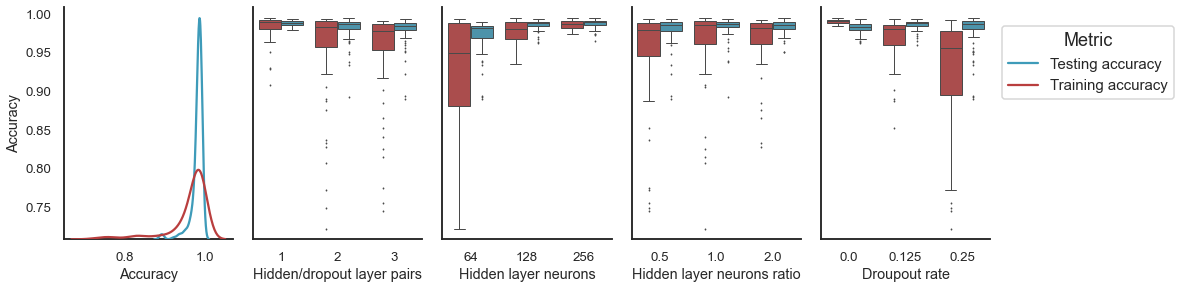

In [278]:
# Plot layout
sns.set_style("white")
sns.set_context("talk", font_scale = 0.8)

# Plot
plot = sns.PairGrid(data=mp_hd_melt, 
                    x_vars = ["value","hidden_dropout_pairs", "hidden_layer_size", "hidden_layer_rate", "dropout_rate"],
                    y_vars = ["value"],
                    hue="variable",
                    palette = ["#b93e3e", "#3e9bb9"],
                    height = 4,
                    aspect = 0.7,
                    layout_pad = 0.1)

plot.map_offdiag(sns.boxplot, linewidth = 1, fliersize = 1)
plot.map_diag(sns.kdeplot)

#Legend
legend = plt.legend(title = "Metric", 
                    labels=["testing_accuracy", "training_accuracy"], 
                    bbox_to_anchor=(6.6,0.95), 
                    title_fontsize = 18,
                    fontsize = 15, 
                    markerscale = 1.2)
legend.get_texts()[0].set_text('Testing accuracy')
legend.get_texts()[1].set_text('Training accuracy')

# Axes titles
axes_names = {'value':'Accuracy', 
              "hidden_dropout_pairs":"Hidden/dropout layer pairs", 
              "hidden_layer_size": "Hidden layer neurons", 
              "hidden_layer_rate":"Hidden layer neurons ratio", 
              "dropout_rate": "Droupout rate"}
for i in range(5):
    if plot.axes[0][i].get_xlabel() in axes_names.keys():
        plot.axes[0][i].set_xlabel(axes_names[plot.axes[0][i].get_xlabel()])
    if plot.axes[0][i].get_ylabel() in axes_names.keys():
        plot.axes[0][i].set_ylabel(axes_names[plot.axes[0][i].get_ylabel()])

# PNG export
plt.savefig("Hidden and dropout layers optimisation.png")

### Optimum hidden and dropout layer parameters

In [279]:
# Weighted average accuracy
model_performance_hd['average_accuracy'] = (model_performance_hd["training_accuracy"]*3 + model_performance_hd["testing_accuracy"])/4

# Best model structure for predictions on both training and testing data over triplicate model training and evaluation
max_accuracy = 0 
for i in range(0,len(model_performance_hd),3):
    accuracy = model_performance_hd["average_accuracy"][i:i+2].mean()
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_hd_index = [i,i+1,i+2]

# Best models
print(f"Best model by performance on training data: ", model_performance_hd["training_accuracy"].idxmax())
print(f"Best model by performance on testing data: ", model_performance_hd["testing_accuracy"].idxmax())
print(f"Best model by performance on training and testing data: ", model_performance_hd["average_accuracy"].idxmax())
print(f"Best models by performance on training and testing data over three model runs: ", best_hd_index)

best_hd_model = model_performance_hd.loc[(
    (model_performance_hd['hidden_dropout_pairs'] == model_performance_hd['hidden_dropout_pairs'][best_hd_index[0]]) &
    (model_performance_hd['hidden_layer_size'] == model_performance_hd['hidden_layer_size'][best_hd_index[0]]) &
    (model_performance_hd['hidden_layer_rate'] == model_performance_hd['hidden_layer_rate'][best_hd_index[0]]) &
    (model_performance_hd['dropout_rate'] == model_performance_hd['dropout_rate'][best_hd_index[0]]))]

print(f"Average prediction accuracy on training data:", round(best_hd_model["training_accuracy"].mean(),3), "+/-", round(best_hd_model["training_accuracy"].std(),3))
print(f"Average prediction accuracy on testing data:", round(best_hd_model["testing_accuracy"].mean(),3), "+/-", round(best_hd_model["testing_accuracy"].std(),3))

Best model by performance on training data:  10
Best model by performance on testing data:  107
Best model by performance on training and testing data:  10
Best models by performance on training and testing data over three model runs:  [21, 22, 23]
Average prediction accuracy on training data: 0.993 +/- 0.001
Average prediction accuracy on testing data: 0.99 +/- 0.0


# Selected model


## Selected model training

In [280]:
# Selected convolutional/pooling layers parametrs
conv_pool_pairs = model_performance_cp['conv_pool_pairs'][best_cp_index[0]] # Number of convolutional and pooling layer pairs
conv_kernel = model_performance_cp['conv_kernel'][best_cp_index[0]] # Size of convolutional kernel (px)
pool_kernel = model_performance_cp['pool_kernel'][best_cp_index[0]] # Size of pooling kernel (px) 
conv_filters = model_performance_cp['conv_filters'][best_cp_index[0]] # Number of filters in first convolution layer
conv_filters_rate = model_performance_cp['conv_filters_rate'][best_cp_index[0]] # Factor for increase of number of filters in each subsequent convolutional layer

In [281]:
# Selected hidden/dropout layers parametrs
hidden_dropout_pairs = model_performance_hd['hidden_dropout_pairs'][best_hd_index[0]] # Number of hidden and dropout layer pairs
hidden_layer_size = model_performance_hd['hidden_layer_size'][best_hd_index[0]] # Number of neurons in hidden layer
hidden_layer_rate = model_performance_hd['hidden_layer_rate'][best_hd_index[0]] # Factor for increase of number of neurons in each subsequent hidden layer
dropout_rate = model_performance_hd['dropout_rate'][best_hd_index[0]] # Dropout rate

### Selecting optimum number of epochs

In [282]:
# Model training variables
epochs= 30
test_size = 0.25

In [285]:
# Build and compile CNN model 
model = build_model(img_height, img_width, n_classes, conv_pool_pairs, conv_kernel, pool_kernel, conv_filters, 
                    conv_filters_rate, hidden_dropout_pairs, hidden_layer_size, hidden_layer_rate, dropout_rate, 'False')

# Train CNN model
model_performance = train_model(train_images, train_labels, test_size, model, epochs)

40 40 43 2 4 2 64 2 1 256 1.0 0.125
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 40, 40, 64)        3136      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 128)       131200    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               3277056   
_________________________________________________________________
dropout_2 (Dropout

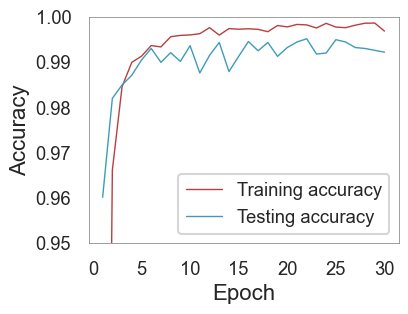

In [303]:
# Layout 
plt.figure(figsize = (4,3), dpi = 100, frameon = False)
plt.rc('axes', edgecolor='#777', linewidth = 0.5)

# Plot
plt.plot(list(np.arange(1, 31)), model_performance.history['accuracy'], label='Training accuracy', color = "#b93e3e", linewidth = 1)
plt.plot(list(np.arange(1, 31)), model_performance.history['val_accuracy'], label = 'Testing accuracy', color = '#3e9bb9', linewidth = 1)

# Axes
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([0.95, 1])
plt.xticks(np.arange(0, 31, step=5))
plt.yticks(np.arange(0.95, 1.005, step=0.01))

# Legend
plt.legend(loc=4)
plt.savefig("Epochs.png")

In [304]:
# Best model
## Training data
for i in range(epochs):
    if model_performance.history['accuracy'][i] == max(model_performance.history['accuracy']):
        best_training_epoch = i + 1 # Epochs start at 1, not 0
        
## Testing data
for i in range(epochs):
    if model_performance.history['val_accuracy'][i] == max(model_performance.history['val_accuracy']):
        best_testing_epoch = i + 1 # Epochs start at 1, not 0

## Training and testing data
max_accuracy = 0 
for i in range(1, epochs):
    accuracy = (model_performance.history['accuracy'][i]*3 + model_performance.history['val_accuracy'][i])/4
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_tt_epoch = i  + 1 # Epochs start at 1, not 0

print(f"Best model by performance on training data obtained at epoch: ", best_training_epoch)
print(f"Best model by performance on testing data obtained at epoch: ", best_testing_epoch)
print(f"Best model by performance on training and testing data obtained at epoch: ", best_tt_epoch)

Best model by performance on training data obtained at epoch:  29
Best model by performance on testing data obtained at epoch:  22
Best model by performance on training and testing data obtained at epoch:  22


### Training model with selected epoch number and all training data

In [305]:
epochs = best_tt_epoch

# Build and compile CNN model 
model = build_model(img_height, img_width, n_classes, conv_pool_pairs, conv_kernel, pool_kernel, conv_filters, 
                    conv_filters_rate, hidden_dropout_pairs, hidden_layer_size, hidden_layer_rate, dropout_rate, 'True')

# Train CNN model
labels = tf.keras.utils.to_categorical(train_labels)
images = np.array(train_images)
train_performance = model.fit(images, labels, epochs=epochs)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 40, 40, 64)        3136      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 128)       131200    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               3277056   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

## Selected model validation

In [306]:
# Transform x and y data
val_labels = tf.keras.utils.to_categorical(validation_labels)
val_images = np.array(validation_images)

# Predict validation data
predictions = np.argmax(model.predict(val_images, verbose=0), axis = 1)

# Validaion data accuracy
validation_accuracy = accuracy_score(y_true = np.argmax(validation_labels, axis = 1), y_pred = predictions)
print(f"Validation data accuracy: ", round(validation_accuracy,3))

# Confusion matrix
confusion_matrix_validation = confusion_matrix(y_true = np.argmax(validation_labels, axis = 1), y_pred = predictions, normalize = "true")

Validation data accuracy:  0.971


In [307]:
# Confusion matrix plot
fig = px.imshow(confusion_matrix_validation, color_continuous_scale='Blues')

# Layout
fig.update_layout(
    autosize=False,
    width=900,
    height=900,
    margin={'l': 50, 'r': 20, 't':  20, 'b': 50},
    template="simple_white",
    xaxis_showticklabels=False,
    yaxis_showticklabels=False)

fig.update_xaxes(
        title_text = "True class",
        title_standoff = 30,
        title_font_size = 16)

fig.update_yaxes(
        title_text = "Predicted class",
        title_standoff = 30,
        title_font_size = 16)

# Axess labels - traffic road sign images
images = ["bv6Fznf", "DVr34X9", "d4cdZCy", "F7MkBJn", "41xqB89", "CtFW28t", "Xj2CS23", "cF8YTfL", "Cbj0NyQ", "tbVFVgL", 
          "vzc91p9", "wwvr5KP", "FXwVQN1", "8YHdrwg", "RbhDT0z", "YQfB5pt", "NCzPMBX", "vzCggg4", "7Ry9pzv", "PGQX8sb",
          "sW3Jr8W", "mcYTmM3", "jHJ7Xp0", "Z8zr6wK", "N74Bhhz", "B3tFC1M", "3Fs6TnY", "qyfbcjk", "vhDrGhJ", "RHXQMdC",
          "d6Wtk5S", "VJc6m9S", "mGj2Yc0", "m4zfJNM", "MVYGpPy", "GphzNxr", "514jxQ8", "gPKg1tr", "Thyy7v3", "HYCWsbh",
          "YP7ZHDH", "6rtHGKg", "Wp9NDmB"]

for i in range(0,43):
    source = str("https://i.ibb.co/"+images[i]+"/image.png")
    fig.add_layout_image(dict(
            source=source,
            x=0.023+i*0.02323,
            y=0.028))
    fig.add_layout_image(dict(
            source=source,
            x = -0.013,
            y = 0.924-i*0.02065))

fig.update_layout_images(dict(
        xref="paper",
        yref="paper",
        sizex=0.022,
        sizey=0.022,
        xanchor="right",
        yanchor="bottom"))

# HTML export
fig.write_html("Confusion matrix.html")